# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [2]:
import tensorflow as tf
#import tensorflow.compat.v1 as tf
import csv
import numpy as np
import pandas as pd
import os
from PIL import Image

from keras import Model
#from tensorflow.keras.models import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon

### Change directory

In [3]:
# Not required to change directory. Howeer we will determine current working directory
curr_dir=os.getcwd()
print(curr_dir)

D:\Anaconda\Lab_work\Advanced_Computer_Vision_Lab


### Load the training data from train.csv file

In [4]:
train_df= pd.read_csv("train_labels.csv")
train_df.head(10) 

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127
5,raccoon-69.jpg,205,246,raccoon,12,11,188,240
6,raccoon-180.jpg,600,400,raccoon,119,21,368,399
7,raccoon-200.jpg,261,193,raccoon,107,10,249,166
8,raccoon-141.jpg,249,202,raccoon,1,1,154,176
9,raccoon-19.jpg,259,194,raccoon,87,8,182,89


### Print the shape of the train dataset

In [5]:
train_df.shape

(173, 8)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [6]:
# Additionally setting up few other parameters also
output_dir="\\images_racoon"
TRAIN_CSV="train_labels.csv"
ALPHA = 1.0    # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower
IMAGE_SIZE = 128       # MobileNet takes images of size 128*128*3 
EPOCHS = 10    # Number of epochs. 
BATCH_SIZE = 32 # Depends on your GPU or CPU RAM.

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [7]:
import csv
with open(TRAIN_CSV, 'r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile), 4))
    reader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    firstline=0
    for col, row in enumerate(reader):
      if col!=0:
        for i, r in enumerate(row[1:8]):
          if i!=0 and i!=2:
            row[i+1] = int(r)
        path, image_width, image_height,_, x0, y0, x1, y1 = row  
        path = os.getcwd()+output_dir+ "\images\\" +path
        coords[col, 0] = x0 * IMAGE_SIZE / int(image_width) # Normalize bounding box by image size
        coords[col, 1] = y0 * IMAGE_SIZE / int(image_height) # Normalize bounding box by image size
        coords[col, 2] = (x1 - x0) * IMAGE_SIZE / int(image_width) # Normalize bounding box by image size
        coords[col, 3] = (y1 - y0) * IMAGE_SIZE / int(image_height)
        paths.append(path)

In [8]:
coords = np.delete(coords, (0), axis=0)

In [9]:
coords.shape

(173, 4)

In [10]:
print(path)

D:\Anaconda\Lab_work\Advanced_Computer_Vision_Lab\images_racoon\images\raccoon-152.jpg


### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [11]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i, f in enumerate(paths):
    img = Image.open(f) # Read image
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

In [12]:
batch_images.shape

(173, 128, 128, 3)

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [60]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet

# Freeze layers of model
for layer in model.layers:
    layer.trainable = False

# Adding new layer of same size for our purpose
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)

In [61]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
__________

### Define a custom loss function IoU which calculates Intersection Over Union

In [62]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [63]:
model.compile(optimizer='Adam', loss='mse', metrics=[IoU])
model.fit(batch_images,coords, epochs=45,batch_size = 64,verbose=1)

Epoch 1/45
173/173 [==============================] - 3s 18ms/step - loss: 3720.7760 - IoU: 0.0309
Epoch 2/45
173/173 [==============================] - 3s 15ms/step - loss: 1729.3749 - IoU: 0.1586
Epoch 3/45
173/173 [==============================] - 3s 15ms/step - loss: 796.0426 - IoU: 0.3810
Epoch 4/45
173/173 [==============================] - 3s 15ms/step - loss: 524.7484 - IoU: 0.5132
Epoch 5/45
173/173 [==============================] - 3s 15ms/step - loss: 622.8062 - IoU: 0.5434
Epoch 6/45
173/173 [==============================] - 3s 15ms/step - loss: 687.6639 - IoU: 0.5266
Epoch 7/45
173/173 [==============================] - 3s 15ms/step - loss: 610.6785 - IoU: 0.5226
Epoch 8/45
173/173 [==============================] - 3s 15ms/step - loss: 455.7176 - IoU: 0.5548
Epoch 9/45
173/173 [==============================] - 3s 15ms/step - loss: 333.0721 - IoU: 0.6033
Epoch 10/45
173/173 [==============================] - 3s 15ms/step - loss: 276.2290 - IoU: 0.6040
Epoch 11/45
173/1

### Pick a test image from the given data

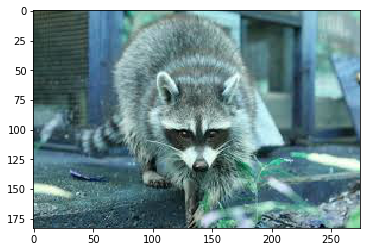

In [98]:
import cv2
filename = os.getcwd()+output_dir+"\images\\raccoon-185.jpg"
unscaled = cv2.imread(filename) # Original image for display
import matplotlib.pyplot as plt
imgplot = plt.imshow(unscaled)
plt.show()

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [99]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [100]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

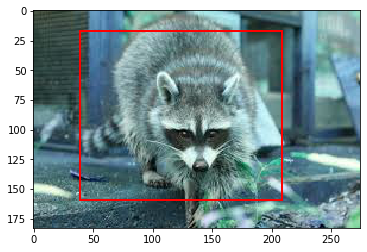

In [101]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np



# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()